# Python Linear Algebra_Part 5: Network, Assignment, Nonlinear Problem
## Full Day Workshop for user learn Data Science with Python
## 2018 Timothy CL Lam
This is meant for internal usage, part of contents copied externally, not for commercial purpose`

# Nonlinearity & Constraint Programming
http://ibmdecisionoptimization.github.io/docplex-doc/mp_vs_cp.html

# Network models


## CPLEX Network Optimizer

As you’ve now seen, many network problems are special types of LP problems. In many cases, using the Simplex or Dual-simplex Optimizers is the most efficient way to solve them. In some cases, specialized algorithms can solve such problems more efficiently. 

CPLEX automatically invokes the Network Optimizer  when it's likely that it would improve solution time compared to the other algorithms. 

It is also possible to force the use (or not) of the Network Optimizer by setting the `lpopt` parameter of
a DOcplex model to 3 (remember 1 was primal simplex, 2 was dual simplex, and 4 is for barrier). 

## Networks in real life

Several problems encountered in Operations Research (OR) involve networks, such as:

- **Distribution problems** (for example, transportation networks)
- **Assignment problems** (for example, networks of workers and jobs they could be assigned to)
- **Planning problems** (for example, critical path analysis for project planning)

Many network models are special LP problems for which specialized solution algorithms exist. 

It is important to know whether a problem can be formulated as a network model to exploit the special structure.

This topic introduces networks in general, as well as some well-known instances of network models.

## Network modeling concepts

Any network structure can be described using two types of objects:

- Nodes: Defined points in the network (for example warehouses)
- Arcs: An arc connects two nodes (for example a road connecting two warehouses) 

An arc can be _directed_, which means than an arc $a_{ij}$ from node $i$ to node $j$ is different from arc $a_ji$ that begins at node $j$ and ends at node $i$.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_5.png?raw=true" >
</ul> 

 A sequence of arcs connecting two nodes is called a **chain**. Each arc in a chain shares exactly one node with the preceding arc.

 When all the arcs in a chain are directed such that it is possible to traverse the chain in the directions of the arcs from the start node to the end node, it is called a **path**.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_6.png?raw=true" >
</ul> 

## Different types of network problems

The following are some well-known types of network problems:
- Transportation problem
- Transshipment problem
- Assignment problem
- Shortest path problem
- Critical path analysis

Next, you'll learn how to recognize each of these, and how their special structure can be exploited.

### The Transportation Problem

One of the most common real-world network problems is the transportation problem.  
This type of problem involves a set of supply nodes and a set of demand nodes.  
The objective is to minimize the transportation cost from the supply nodes to the demand nodes, 
so as to satisfy the demand, and without exceeding the suppliers’ capacities.  

Such a problem can be depicted in a graph, with 
- supply nodes, 
- demand nodes,
- connecting arcs
- The supply capacity is indicated with the supply nodes, 
- while the demand is indicated with the demand nodes, 
- and the transportation costs are indicated on the arcs.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_8.png?raw=true" >
</ul> 

The LP formulation involves one type of variable, namely x(i,j) representing the quantity transported from supply node i to demand node j.  The objective is to minimize the total transportation cost across all arcs.  
The constraints are flow conservation constraints.  
- The first two constraints state that the outflow from each supply node should be less than or equal to the supply capacity.  
- The next three constraints state that the inflow into each demand node should equal the demand at that node.   
- The domain for the shipments on the allowable arcs is set to be greater than or equal to zero, 
- while the shipment quantities on the disallowed arcs are set to zero.  

Even though arcs (1,4) and (2,3) do not exist in the graph, the variables are included in the slide to show the special structure of the transportation problem.  If you were to formulate such a model in practice, you’d simply exclude these variables. 

#### Formulating a simple transportation problem with DOcplex

In the next section, we formulate the problem described above using DOcplex.

#### What data for the transpotation problem?

Input nodes are integers ranging in {1, 2}; output nodes are integers ranging from 3 to 5.

The data consists in three Python dictionaries:

- one dictionary gives capacity values for all input nodes
- one dictionary contains demands for all target nodes
- one last dictionary holds cost values for some (source, target) pair of nodes.

In [1]:
capacities = {1: 15, 2: 20}
demands = {3: 7, 4: 10, 5: 15}
costs = {(1,3): 2, (1,5):4, (2,4):5, (2,5):3}

# Python ranges will be used to iterate on source, target nodes.
source = range(1, 3) # {1, 2}
target = range(3, 6) # {3,4,5}

#### Create a model instance

In [2]:
from docplex.mp.model import Model

tm = Model(name='transportation')

#### Define the decision variables

In [3]:
# create flow variables for each couple of nodes
# x(i,j) is the flow going out of node i to node j
x = {(i,j): tm.continuous_var(name='x_{0}_{1}'.format(i,j)) for i in source for j in target}

# each arc comes with a cost. Minimize all costed flows
tm.minimize(tm.sum(x[i,j]*costs.get((i,j), 0) for i in source for j in target))

tm.print_information()

Model: transportation
 - number of variables: 6
   - binary=0, integer=0, continuous=6
 - number of constraints: 0
   - linear=0
 - parameters: defaults


#### Set up the constraints

- For each source node, the total outbound flow must be smaller than available quantity.
- For each target node, total inbound flow must be greater thand demand

In [4]:
# for each node, total outgoing flow must be smaller than available quantity
for i in source:
    tm.add_constraint(tm.sum(x[i,j] for j in target) <= capacities[i])
    
# for each target node, total ingoing flow must be greater thand demand
for j in target:
    tm.add_constraint(tm.sum(x[i,j] for i in source) >= demands[j])

#### Express the business objective: minimize total flow cost

Each arc has a unit cost and we want to minimize the total cost. If an arc has no entry in the dictionary, we assume a zero cost (using the `dict.get` method.

In [5]:
tm.minimize(tm.sum(x[i,j]*costs.get((i,j), 0)))

### Solve with the Decision Optimization solve service

If url and key are None, the Modeling layer will look for a local runtime, otherwise will use the credentials.

Look at the documentation for a good understanding of the various solving/generation modes.

If you're using a Community Edition of CPLEX runtimes, depending on the size of the problem, the solve stage may fail and will need a paying subscription or product installation.

In any case, `Model.solve()` returns a solution object in Python, containing the optimal values of decision variables, if the solve succeeds, or else it returns `None`.

In [6]:
url = "https://api-oaas.docloud.ibmcloud.com/job_manager/rest/v1"
key = "bm_api_ext_6139fa6a-2265-4148-bb9f-d18ffa78ed7c"

In [7]:
tms = tm.solve(url=url, key=key)
assert tms
tms.display()

solution for: transportation
objective: 0.000
x_1_5 = 15.000
x_2_3 = 7.000
x_2_4 = 10.000


### Special structure of  network problem

The special structure of the transportation problem, as well as many other types of network problems, allows the use of specialized algorithms that lead to significant reductions in solution time.

#### Another important characteristic of transportation problems (and also some other network problems) is that if all the capacities and demands are integer, then the decision variables will take integer values.


This is important to know, because it means that you do not have to use integer variables in such cases. 

As you'll learn in a later topic, integer variables often lead to problems that require much more computational effort compared to problems with only continuous variables.


In [ ]:
from collections import namedtuple

In [ ]:
_parameters = namedtuple('parameters', ['maxTrucks', 'maxVolume'])
_location = namedtuple('location', ['name'])
_spoke = namedtuple('spoke', ['name', 'minDepTime', 'maxArrTime'])
_truckType = namedtuple('truckType', ['truckType', 'capacity', 'costPerMile', 'milesPerHour'])
_loadTimeInfo = namedtuple('loadTimeInfo', ['hub', 'truckType', 'loadTime'])
_routeInfo = namedtuple('routeInfo', ['spoke', 'hub', 'distance'])
_triple = namedtuple('triple', ['origin', 'hub', 'destination'])
_shipment = namedtuple('shipment', ['origin', 'destination', 'totalVolume'])



In [ ]:
import requests
import json
import decimal 
r = requests.get("https://github.com/vberaudi/utwt/blob/master/trucking.json?raw=true")
json_data = json.loads(r.text, parse_float=decimal.Decimal )    

In [ ]:
def read_json_tuples(name, my_namedtuple):
    json_fragment = json_data[name]
    length = len(my_namedtuple._fields)
    ret = []
    for t in json_fragment:
        #print t
        ret2 = [0 for i in range(length)]
        for i in  range(length):
            field = my_namedtuple._fields[i]
            ret2[i] = t[field]
        ret.append(my_namedtuple(*tuple(ret2)))
    return ret

def read_json_tuple(name, my_namedtuple):
    json_fragment = json_data[name]
    length = len(my_namedtuple._fields)
    ret = [0 for i in range(length)]
    for i in  range(length):
        field = my_namedtuple._fields[i]
        ret[i] = json_fragment[field]
    return my_namedtuple(*tuple(ret))

Use basic HTML and a stylesheet to format the data.

In [ ]:
CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
    table.dataframe thead th:first-child {
        display: none;
    }
    table.dataframe tbody th {
        display: none;
    }
"""

from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))

In [ ]:
parameters = read_json_tuple(name='Parameters', my_namedtuple=_parameters)
hubs = read_json_tuples(name='Hubs', my_namedtuple=_location)
truckTypes = read_json_tuples(name='TruckTypes', my_namedtuple=_truckType)
spokes = read_json_tuples(name='Spokes', my_namedtuple=_spoke)
loadTimes = read_json_tuples(name='LoadTimes', my_namedtuple=_loadTimeInfo)
routes = read_json_tuples(name='Routes', my_namedtuple=_routeInfo)
shipments = read_json_tuples(name='Shipments', my_namedtuple=_shipment)

### Step 4: Prepare the data

Given the number of teams in each division and the number of intradivisional and interdivisional games to be played, you can calculate the total number of teams and the number of weeks in the schedule, assuming every team plays exactly one game per week. 


The season is split into halves, and the number of the intradivisional games that each team must play in the first half of the season is calculated.

In [ ]:
maxTrucks = parameters.maxTrucks;
maxVolume = parameters.maxVolume;

hubIds = {h.name for h in hubs}

spokeIds = {s.name for s in spokes}
spoke = {s.name : s for s in spokes}

truckTypeIds = {ttis.truckType for ttis in truckTypes}
truckTypeInfos = {tti.truckType : tti for tti in truckTypes}

loadTime = {(lt.hub , lt.truckType) : lt.loadTime for lt in loadTimes}

# feasible pathes from spokes to spokes via one hub
triples = {_triple(r1.spoke, r1.hub, r2.spoke) for r1 in routes for r2 in routes if (r1 != r2 and r1.hub == r2.hub)}

Some asserts to check the data follows the guidelines.

In [ ]:
# Make sure the data is consistent: latest arrive time >= earliest departure time
for s in spokeIds:
    assert spoke[s].maxArrTime > spoke[s].minDepTime, "inconsistent data"

# The following assertion is to make sure that the spoke
# in each route is indeed in the set of Spokes.
for r in routes:
    assert r.spoke in spokeIds, "some route is not in the spokes"

# The following assertion is to make sure that the hub
# in each route are indeed in the set of Hubs.
for r in routes:
    assert r.hub in hubIds, "some route is not in the hubs"

# The following assertion is to make sure that the origin
# of each shipment is indeed in the set of Spokes.
for s in shipments:
    assert s.origin in spokeIds, "origin is not in the set of Spokes"

# The following assertion is to make sure that the destination
# of each shipment is indeed in the set of Spokes.
for s in shipments:
    assert s.destination in spokeIds, "shipment is not in the set of Spokes"

In [ ]:
from math import ceil, floor
# the earliest unloading time at a hub for each type of trucks
earliestUnloadingTime = {(r, t) : int(ceil(loadTime[r.hub, t] + spoke[r.spoke].minDepTime + 60 * r.distance / truckTypeInfos[t].milesPerHour)) for t in truckTypeIds for r in routes}
# the latest loading time at a hub for each type of trucks
latestLoadingTime = {(r, t) : int(floor(spoke[r.spoke].maxArrTime - loadTime[r.hub, t] - 60 * r.distance / truckTypeInfos[t].milesPerHour)) for t in truckTypeIds for r in routes}

# Compute possible truck types that can be assigned on a route
# A type of truck can be assigned on a route only if it can make it to the hub and back
#  before the max arrival time at the spoke.
possibleTruckOnRoute =  {(r, t) : 1 if earliestUnloadingTime[r, t] < latestLoadingTime[r, t] else 0 for t in truckTypeIds for r in routes}

### Step 5: Set up the prescriptive model

In [ ]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

#### Create the DOcplex model
The model contains all the business constraints and defines the objective.

In [ ]:
from docplex.mp.model import Model

model = Model("truck")

#### Define the decision variables

In [ ]:
truckOnRoute = model.integer_var_matrix(keys1=routes, keys2=truckTypeIds, lb=0, ub=maxTrucks, name="TruckOnRoute")

# This represents the volumes shipped out from each hub
# by each type of trucks on each triple
# The volumes are distinguished by trucktypes because trucks of different types
# arrive at a hub at different times and the timing is used in defining
# the constraints for volume availability for the trucks leaving the hub.
outVolumeThroughHubOnTruck = model.integer_var_matrix(keys1=triples, keys2=truckTypeIds, lb=0, ub=maxVolume, name="OutVolumeThroughHubOnTruck")

# This represents the volume shipped into each hub by each type of trucks on each triple
# It is used in defining timing constraints.
inVolumeThroughHubOnTruck = model.integer_var_matrix(keys1=triples, keys2=truckTypeIds, lb=0, ub=maxVolume, name="InVolumeThroughHubOnTruck")

#### Express the business constraints

##### The number of trucks of each type should be less than "maxTrucks", and if a type of truck is impossible for a route, its number should be zero

In [ ]:
for r in routes:
    for t in truckTypeIds:
        model.add_constraint(truckOnRoute[r, t] <= possibleTruckOnRoute[r, t] * maxTrucks)

##### On each route s-h, the total inbound volume carried by trucks of each type should be less than the total capacity of the trucks of this type.

In [ ]:
for (s,h,dist) in routes:
    for t in truckTypeIds:
        model.add_constraint(
            model.sum(inVolumeThroughHubOnTruck[(s1, h1, dest), t] for (s1, h1, dest) in triples if s == s1 and h1 == h)
              <= truckOnRoute[(s, h, dist), t] * truckTypeInfos[t].capacity
        )

##### On any triple, the total flows in the hub = the total flows out the hub

In [ ]:
for tr in triples:
    model.add_constraint(
        model.sum(inVolumeThroughHubOnTruck[tr, t] for t in truckTypeIds)
        == model.sum(outVolumeThroughHubOnTruck[tr, t] for t in truckTypeIds)
    )

##### The sum of flows between any origin-destination pair via all hubs is equal to the shipment between the o-d pair.

In [ ]:
for (o,d,v) in shipments:
    model.add_constraint(model.sum(inVolumeThroughHubOnTruck[(o1, h, d1), t] for t in truckTypeIds for (o1, h, d1) in triples if o1 == o and d1 == d) == v)

##### There must be enough volume for a truck before it leaves a hub. 
In another words, the shipments for a truck must arrive at the hub from all spokes before the truck leaves. 
The constraint can be expressed as the following: For each route s-h and leaving truck of type t:  Cumulated inbound volume arrived before the loading time of the truck >= Cumulated outbound volume upto the loading time of the truck(including the shipments being loaded).

In [ ]:
for (s,h,dist) in routes:
    for t in truckTypeIds:
        model.add_constraint(
            # The expression below defines the indices of the trucks unloaded before truck t starts loading.
          model.sum(inVolumeThroughHubOnTruck[(o, h, s), t1]
                    for (o,h0,s0) in triples if h0 == h and s0 == s
                    for t1 in truckTypeIds
                    for (o2,h2,dist1) in routes if h2 == h0 and o2 == o
                    if earliestUnloadingTime[(o, h, dist1), t1] <= latestLoadingTime[(s, h, dist), t])
            >=
              # The expression below defines the indices of the trucks left before truck t starts loading.
          model.sum(outVolumeThroughHubOnTruck[(o, h, s), t2]
                    for (o,h0,s0) in triples if h0 == h and s0 == s
                    for t2 in truckTypeIds
                    for (o2,h2,dist2) in routes if h2 == h0 and o2 == o
                    if latestLoadingTime[(o, h, dist2), t2] <= latestLoadingTime[(s, h, dist), t])
        )

#### Express the objective

In [ ]:
totalCost = model.sum(2 * r.distance * truckTypeInfos[t].costPerMile * truckOnRoute[r, t] for r in routes for t in truckTypeIds)

model.minimize(totalCost)

### Solve with the Decision Optimization solve service 

You will get the best solution found after n seconds, due to a time limit parameter.


In [ ]:
model.print_information()

assert model.solve(url=url, key=key), "!!! Solve of the model fails"
model.report()

### Step 6: Investigate the solution and then run an example analysis

In [ ]:
#solution object model
_result = namedtuple('result', ['totalCost'])
_nbTrucksOnRouteRes = namedtuple('nbTrucksOnRouteRes', ['spoke', 'hub', 'truckType', 'nbTruck'])
_volumeThroughHubOnTruckRes = namedtuple('volumeThroughHubOnTruckRes', ['origin', 'hub', 'destination', 'truckType', 'quantity'])
_aggregatedReport = namedtuple('aggregatedReport', ['spoke', 'hub', 'truckType', 'quantity'])

In [ ]:
# Post processing: result data structures are exported as post-processed tuple or list of tuples
# Solve objective value
import pandas as pd
result = _result(totalCost.solution_value)


nbTrucksOnRouteRes = pd.DataFrame([_nbTrucksOnRouteRes(r.spoke, r.hub, t, int(truckOnRoute[r, t]))
                      for r in routes
                      for t in truckTypeIds
                      if int(truckOnRoute[r, t]) > 0])


# Volume shipped into each hub by each type of trucks and each pair (origin, destination)
inVolumeThroughHubOnTruckRes = pd.DataFrame([_volumeThroughHubOnTruckRes(tr.origin, tr.hub, tr.destination, t, int(inVolumeThroughHubOnTruck[tr, t]))
                                for tr in triples
                                for t in truckTypeIds
                                if int(inVolumeThroughHubOnTruck[tr, t]) > 0])


# Volume shipped from each hub by each type of trucks and each pair (origin, destination)
outVolumeThroughHubOnTruckRes = pd.DataFrame([_volumeThroughHubOnTruckRes(tr.origin, tr.hub, tr.destination, t, int(outVolumeThroughHubOnTruck[tr, t]))
                                 for tr in triples
                                 for t in truckTypeIds
                                 if int(outVolumeThroughHubOnTruck[tr, t]) > 0])

inBoundAggregated = pd.DataFrame([_aggregatedReport(r.spoke, r.hub, t, sum(int(inVolumeThroughHubOnTruck[tr, t])
                                                              for tr in triples if tr.origin == r.spoke and tr.hub == r.hub))
                     for r in routes
                     for t in truckTypeIds
                     if int(truckOnRoute[r, t]) > 0])
outBoundAggregated = pd.DataFrame([_aggregatedReport(r.spoke, r.hub, t, sum(int(outVolumeThroughHubOnTruck[tr, t])
                                                               for tr in triples if tr.destination == r.spoke and tr.hub == r.hub))
                      for r in routes
                      for t in truckTypeIds
                      if int(truckOnRoute[r, t]) > 0])

In [ ]:
from IPython.display import display

In [ ]:
display(nbTrucksOnRouteRes)

In [ ]:
display(inVolumeThroughHubOnTruckRes)

In [ ]:
display(outVolumeThroughHubOnTruckRes)

In [ ]:
display(inBoundAggregated)

In [ ]:
display(outBoundAggregated)

## The Transshipment Problem

The transshipment problem is similar to the transportation problem, except that intermediate nodes exist in addition to the supply and demand nodes.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_10.png?raw=true" >
</ul> 


In this example, nodes 3 and 4 are intermediate nodes.  

The LP formulation is also similar, in the sense that it involves 
- an objective to minimize the transportation cost across all arcs, and a set of flow conservation constraints.  
- The first two constraints are for the supply nodes, and state that the outflow from each supply node should equal the capacity of that node, plus any inflow into that same node. 
- The next two constraints are for the intermediate nodes, and state that the inflow into an intermediate node should equal the outflow out of that node.  
- The last two constraints are for the demand nodes, and state that the inflow into each demand node should equal the demand at that node.  The domain for the variables is to be greater than or equal to zero. 


## Example:  Transportation Optimization Problem  


* A trucking company has a hub and spoke system. The shipments to be delivered are specified by an originating spoke, a destination spoke, and a shipment volume. The trucks have different types defined by a maximum capacity, a speed, and a cost per mile. The model assigns the correct number of trucks to each route in order to minimize the cost of transshipment and meet the volume requirements. There is a minimum departure time and a maximum return time for trucks at a spoke, and a load and unload time at the hub. Trucks of different types travel at different speeds. Therefore, shipments are available at each hub in a timely manner. Volume availability constraints are taken into account, meaning that the shipments that will be carried back from a hub to a spoke by a truck must be available for loading before the truck leaves.

* The assumptions are:

   * Exactly the same number of trucks that go from spoke to hub return from hub to spoke.
   * Each truck arrives at a hub as early as possible and leaves as late as possible.
   * The shipments can be broken arbitrarily into smaller packages and shipped through different paths.

In [8]:
from collections import namedtuple

In [9]:
_parameters = namedtuple('parameters', ['maxTrucks', 'maxVolume'])
_location = namedtuple('location', ['name'])
_spoke = namedtuple('spoke', ['name', 'minDepTime', 'maxArrTime'])
_truckType = namedtuple('truckType', ['truckType', 'capacity', 'costPerMile', 'milesPerHour'])
_loadTimeInfo = namedtuple('loadTimeInfo', ['hub', 'truckType', 'loadTime'])
_routeInfo = namedtuple('routeInfo', ['spoke', 'hub', 'distance'])
_triple = namedtuple('triple', ['origin', 'hub', 'destination'])
_shipment = namedtuple('shipment', ['origin', 'destination', 'totalVolume'])



In [10]:
import requests
import json
import decimal 
r = requests.get("https://github.com/vberaudi/utwt/blob/master/trucking.json?raw=true")
json_data = json.loads(r.text, parse_float=decimal.Decimal )    

In [11]:
def read_json_tuples(name, my_namedtuple):
    json_fragment = json_data[name]
    length = len(my_namedtuple._fields)
    ret = []
    for t in json_fragment:
        #print t
        ret2 = [0 for i in range(length)]
        for i in  range(length):
            field = my_namedtuple._fields[i]
            ret2[i] = t[field]
        ret.append(my_namedtuple(*tuple(ret2)))
    return ret

def read_json_tuple(name, my_namedtuple):
    json_fragment = json_data[name]
    length = len(my_namedtuple._fields)
    ret = [0 for i in range(length)]
    for i in  range(length):
        field = my_namedtuple._fields[i]
        ret[i] = json_fragment[field]
    return my_namedtuple(*tuple(ret))

Use basic HTML and a stylesheet to format the data.

In [12]:
CSS = """
body {
    margin: 0;
    font-family: Helvetica;
}
table.dataframe {
    border-collapse: collapse;
    border: none;
}
table.dataframe tr {
    border: none;
}
table.dataframe td, table.dataframe th {
    margin: 0;
    border: 1px solid white;
    padding-left: 0.25em;
    padding-right: 0.25em;
}
table.dataframe th:not(:empty) {
    background-color: #fec;
    text-align: left;
    font-weight: normal;
}
table.dataframe tr:nth-child(2) th:empty {
    border-left: none;
    border-right: 1px dashed #888;
}
table.dataframe td {
    border: 2px solid #ccf;
    background-color: #f4f4ff;
}
    table.dataframe thead th:first-child {
        display: none;
    }
    table.dataframe tbody th {
        display: none;
    }
"""

from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))

In [13]:
parameters = read_json_tuple(name='Parameters', my_namedtuple=_parameters)
hubs = read_json_tuples(name='Hubs', my_namedtuple=_location)
truckTypes = read_json_tuples(name='TruckTypes', my_namedtuple=_truckType)
spokes = read_json_tuples(name='Spokes', my_namedtuple=_spoke)
loadTimes = read_json_tuples(name='LoadTimes', my_namedtuple=_loadTimeInfo)
routes = read_json_tuples(name='Routes', my_namedtuple=_routeInfo)
shipments = read_json_tuples(name='Shipments', my_namedtuple=_shipment)

### Truck Example: Prepare the data

Given the number of teams in each division and the number of intradivisional and interdivisional games to be played, you can calculate the total number of teams and the number of weeks in the schedule, assuming every team plays exactly one game per week. 


The season is split into halves, and the number of the intradivisional games that each team must play in the first half of the season is calculated.

In [14]:
maxTrucks = parameters.maxTrucks;
maxVolume = parameters.maxVolume;

hubIds = {h.name for h in hubs}

spokeIds = {s.name for s in spokes}
spoke = {s.name : s for s in spokes}

truckTypeIds = {ttis.truckType for ttis in truckTypes}
truckTypeInfos = {tti.truckType : tti for tti in truckTypes}

loadTime = {(lt.hub , lt.truckType) : lt.loadTime for lt in loadTimes}

# feasible pathes from spokes to spokes via one hub
triples = {_triple(r1.spoke, r1.hub, r2.spoke) for r1 in routes for r2 in routes if (r1 != r2 and r1.hub == r2.hub)}

Some asserts to check the data follows the guidelines.

In [15]:
# Make sure the data is consistent: latest arrive time >= earliest departure time
for s in spokeIds:
    assert spoke[s].maxArrTime > spoke[s].minDepTime, "inconsistent data"

# The following assertion is to make sure that the spoke
# in each route is indeed in the set of Spokes.
for r in routes:
    assert r.spoke in spokeIds, "some route is not in the spokes"

# The following assertion is to make sure that the hub
# in each route are indeed in the set of Hubs.
for r in routes:
    assert r.hub in hubIds, "some route is not in the hubs"

# The following assertion is to make sure that the origin
# of each shipment is indeed in the set of Spokes.
for s in shipments:
    assert s.origin in spokeIds, "origin is not in the set of Spokes"

# The following assertion is to make sure that the destination
# of each shipment is indeed in the set of Spokes.
for s in shipments:
    assert s.destination in spokeIds, "shipment is not in the set of Spokes"

In [16]:
from math import ceil, floor
# the earliest unloading time at a hub for each type of trucks
earliestUnloadingTime = {(r, t) : int(ceil(loadTime[r.hub, t] + spoke[r.spoke].minDepTime + 60 * r.distance / truckTypeInfos[t].milesPerHour)) for t in truckTypeIds for r in routes}
# the latest loading time at a hub for each type of trucks
latestLoadingTime = {(r, t) : int(floor(spoke[r.spoke].maxArrTime - loadTime[r.hub, t] - 60 * r.distance / truckTypeInfos[t].milesPerHour)) for t in truckTypeIds for r in routes}

# Compute possible truck types that can be assigned on a route
# A type of truck can be assigned on a route only if it can make it to the hub and back
#  before the max arrival time at the spoke.
possibleTruckOnRoute =  {(r, t) : 1 if earliestUnloadingTime[r, t] < latestLoadingTime[r, t] else 0 for t in truckTypeIds for r in routes}

### Truck Example: Set up the prescriptive model

In [17]:
from docplex.mp.environment import Environment
env = Environment()
env.print_information()

* system is: Linux 64bit
* Python is present, version is 2.7.11
* docplex is present, version is (2, 0, 15)
* CPLEX wrapper is not available


#### Create the DOcplex model
The model contains all the business constraints and defines the objective.

In [18]:
from docplex.mp.model import Model

model = Model("truck")

#### Define the decision variables

In [19]:
truckOnRoute = model.integer_var_matrix(keys1=routes, keys2=truckTypeIds, lb=0, ub=maxTrucks, name="TruckOnRoute")

# This represents the volumes shipped out from each hub
# by each type of trucks on each triple
# The volumes are distinguished by trucktypes because trucks of different types
# arrive at a hub at different times and the timing is used in defining
# the constraints for volume availability for the trucks leaving the hub.
outVolumeThroughHubOnTruck = model.integer_var_matrix(keys1=triples, keys2=truckTypeIds, lb=0, ub=maxVolume, name="OutVolumeThroughHubOnTruck")

# This represents the volume shipped into each hub by each type of trucks on each triple
# It is used in defining timing constraints.
inVolumeThroughHubOnTruck = model.integer_var_matrix(keys1=triples, keys2=truckTypeIds, lb=0, ub=maxVolume, name="InVolumeThroughHubOnTruck")

#### Express the business constraints

##### The number of trucks of each type should be less than "maxTrucks", and if a type of truck is impossible for a route, its number should be zero

In [20]:
for r in routes:
    for t in truckTypeIds:
        model.add_constraint(truckOnRoute[r, t] <= possibleTruckOnRoute[r, t] * maxTrucks)

##### On each route s-h, the total inbound volume carried by trucks of each type should be less than the total capacity of the trucks of this type.

In [21]:
for (s,h,dist) in routes:
    for t in truckTypeIds:
        model.add_constraint(
            model.sum(inVolumeThroughHubOnTruck[(s1, h1, dest), t] for (s1, h1, dest) in triples if s == s1 and h1 == h)
              <= truckOnRoute[(s, h, dist), t] * truckTypeInfos[t].capacity
        )

##### On any triple, the total flows in the hub = the total flows out the hub

In [22]:
for tr in triples:
    model.add_constraint(
        model.sum(inVolumeThroughHubOnTruck[tr, t] for t in truckTypeIds)
        == model.sum(outVolumeThroughHubOnTruck[tr, t] for t in truckTypeIds)
    )

##### The sum of flows between any origin-destination pair via all hubs is equal to the shipment between the o-d pair.

In [23]:
for (o,d,v) in shipments:
    model.add_constraint(model.sum(inVolumeThroughHubOnTruck[(o1, h, d1), t] for t in truckTypeIds for (o1, h, d1) in triples if o1 == o and d1 == d) == v)

##### There must be enough volume for a truck before it leaves a hub. 
In another words, the shipments for a truck must arrive at the hub from all spokes before the truck leaves. 
The constraint can be expressed as the following: For each route s-h and leaving truck of type t:  Cumulated inbound volume arrived before the loading time of the truck >= Cumulated outbound volume upto the loading time of the truck(including the shipments being loaded).

In [24]:
for (s,h,dist) in routes:
    for t in truckTypeIds:
        model.add_constraint(
            # The expression below defines the indices of the trucks unloaded before truck t starts loading.
          model.sum(inVolumeThroughHubOnTruck[(o, h, s), t1]
                    for (o,h0,s0) in triples if h0 == h and s0 == s
                    for t1 in truckTypeIds
                    for (o2,h2,dist1) in routes if h2 == h0 and o2 == o
                    if earliestUnloadingTime[(o, h, dist1), t1] <= latestLoadingTime[(s, h, dist), t])
            >=
              # The expression below defines the indices of the trucks left before truck t starts loading.
          model.sum(outVolumeThroughHubOnTruck[(o, h, s), t2]
                    for (o,h0,s0) in triples if h0 == h and s0 == s
                    for t2 in truckTypeIds
                    for (o2,h2,dist2) in routes if h2 == h0 and o2 == o
                    if latestLoadingTime[(o, h, dist2), t2] <= latestLoadingTime[(s, h, dist), t])
        )

#### Express the objective

In [25]:
totalCost = model.sum(2 * r.distance * truckTypeInfos[t].costPerMile * truckOnRoute[r, t] for r in routes for t in truckTypeIds)

model.minimize(totalCost)

### Truck Example: Solve with the Decision Optimization solve service 

You will get the best solution found after n seconds, due to a time limit parameter.


In [26]:
model.print_information()

assert model.solve(url=url, key=key), "!!! Solve of the model fails"
model.report()

Model: truck
 - number of variables: 188
   - binary=0, integer=188, continuous=0
 - number of constraints: 132
   - linear=132
 - parameters: defaults
* model solved with objective = 25850


### Truck Example: Investigate the solution and then run an example analysis

In [27]:
#solution object model
_result = namedtuple('result', ['totalCost'])
_nbTrucksOnRouteRes = namedtuple('nbTrucksOnRouteRes', ['spoke', 'hub', 'truckType', 'nbTruck'])
_volumeThroughHubOnTruckRes = namedtuple('volumeThroughHubOnTruckRes', ['origin', 'hub', 'destination', 'truckType', 'quantity'])
_aggregatedReport = namedtuple('aggregatedReport', ['spoke', 'hub', 'truckType', 'quantity'])

In [48]:
# Post processing: result data structures are exported as post-processed tuple or list of tuples
# Solve objective value
import pandas as pd
result = _result(totalCost.solution_value)


nbTrucksOnRouteRes = pd.DataFrame([_nbTrucksOnRouteRes(r.spoke, r.hub, t, int(truckOnRoute[r, t]))
                      for r in routes
                      for t in truckTypeIds
                      if int(truckOnRoute[r, t]) > 0])


# Volume shipped into each hub by each type of trucks and each pair (origin, destination)
inVolumeThroughHubOnTruckRes = pd.DataFrame([_volumeThroughHubOnTruckRes(tr.origin, tr.hub, tr.destination, t, int(inVolumeThroughHubOnTruck[tr, t]))
                                for tr in triples
                                for t in truckTypeIds
                                if int(inVolumeThroughHubOnTruck[tr, t]) > 0])


# Volume shipped from each hub by each type of trucks and each pair (origin, destination)
outVolumeThroughHubOnTruckRes = pd.DataFrame([_volumeThroughHubOnTruckRes(tr.origin, tr.hub, tr.destination, t, int(outVolumeThroughHubOnTruck[tr, t]))
                                 for tr in triples
                                 for t in truckTypeIds
                                 if int(outVolumeThroughHubOnTruck[tr, t]) > 0])

inBoundAggregated = pd.DataFrame([_aggregatedReport(r.spoke, r.hub, t, sum(int(inVolumeThroughHubOnTruck[tr, t])
                                                              for tr in triples if tr.origin == r.spoke and tr.hub == r.hub))
                     for r in routes
                     for t in truckTypeIds
                     if int(truckOnRoute[r, t]) > 0])
outBoundAggregated = pd.DataFrame([_aggregatedReport(r.spoke, r.hub, t, sum(int(outVolumeThroughHubOnTruck[tr, t])
                                                               for tr in triples if tr.destination == r.spoke and tr.hub == r.hub))
                      for r in routes
                      for t in truckTypeIds
                      if int(truckOnRoute[r, t]) > 0])

In [29]:
from IPython.display import display

In [30]:
display(nbTrucksOnRouteRes)

,spoke,hub,truckType,nbTruck
0,D,G,BigTruck,1
1,A,H,BigTruck,2
2,B,H,BigTruck,1
3,B,H,SmallTruck,1
4,C,H,BigTruck,1
5,C,H,SmallTruck,1
6,D,H,SmallTruck,1
7,E,H,BigTruck,1
8,F,H,BigTruck,1
9,F,H,SmallTruck,1


In [31]:
display(inVolumeThroughHubOnTruckRes)

,origin,hub,destination,truckType,quantity
0,A,H,C,BigTruck,250
1,B,H,F,SmallTruck,197
2,F,H,E,BigTruck,104
3,A,H,B,BigTruck,300
4,D,H,F,SmallTruck,155
5,A,H,E,BigTruck,145
6,B,H,D,BigTruck,218
7,B,H,D,SmallTruck,3
8,A,H,D,BigTruck,350
9,B,H,E,BigTruck,263


In [32]:
display(outVolumeThroughHubOnTruckRes)

,origin,hub,destination,truckType,quantity
0,A,H,C,SmallTruck,250
1,B,H,F,BigTruck,197
2,F,H,E,BigTruck,104
3,A,H,B,BigTruck,300
4,D,H,F,SmallTruck,155
5,A,H,E,BigTruck,145
6,B,H,D,BigTruck,221
7,A,H,D,BigTruck,350
8,B,H,E,BigTruck,263
9,E,H,D,SmallTruck,78


In [33]:
display(inBoundAggregated)

,spoke,hub,truckType,quantity
0,D,G,BigTruck,493
1,A,H,BigTruck,1345
2,B,H,BigTruck,666
3,B,H,SmallTruck,400
4,C,H,BigTruck,699
5,C,H,SmallTruck,207
6,D,H,SmallTruck,400
7,E,H,BigTruck,685
8,F,H,BigTruck,699
9,F,H,SmallTruck,144


In [34]:
display(outBoundAggregated)

,spoke,hub,truckType,quantity
0,D,G,BigTruck,0
1,A,H,BigTruck,328
2,B,H,BigTruck,478
3,B,H,SmallTruck,391
4,C,H,BigTruck,757
5,C,H,SmallTruck,250
6,D,H,SmallTruck,78
7,E,H,BigTruck,733
8,F,H,BigTruck,710
9,F,H,SmallTruck,155


## The Assignment Problem

The Assignment Problem is the problem of assigning one set of items to another, while optimizing a given objective.  For example, the problem of assigning workers to jobs so as to minimize the hiring costs.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_11.png?raw=true" >
</ul> 

In this example, the workers are represented by nodes 1 through 3, while the jobs are represented with nodes A, B and C.  The cost of assigning a worker to a job is shown on each arc.  
- The objective is to minimize the total assignment cost.  
- Again, the constraints can be seen as flow conservation constraints.  
- The first three constraints state that each job is filled by exactly one person, while the last three constraints state that each person is assigned to exactly one job.  The variables should now take a value of 1 if worker i is assigned to job j, and zero otherwise.  

This problem is a special case of the transportation problem, 
- with each supply node capacity set to one, and each demand set to 1.  
- What’s also important to know is that even though the variables must take 0-1 values, 
- they can be declared as continuous variables due to the integrality property, namely that if all capacity and demand quantities are integer, the variables will take integer values.

In [ ]:
## The business problem:  Transportation Optimization Problem  


* A trucking company has a hub and spoke system. The shipments to be delivered are specified by an originating spoke, a destination spoke, and a shipment volume. The trucks have different types defined by a maximum capacity, a speed, and a cost per mile. The model assigns the correct number of trucks to each route in order to minimize the cost of transshipment and meet the volume requirements. There is a minimum departure time and a maximum return time for trucks at a spoke, and a load and unload time at the hub. Trucks of different types travel at different speeds. Therefore, shipments are available at each hub in a timely manner. Volume availability constraints are taken into account, meaning that the shipments that will be carried back from a hub to a spoke by a truck must be available for loading before the truck leaves.

* The assumptions are:

   * Exactly the same number of trucks that go from spoke to hub return from hub to spoke.
   * Each truck arrives at a hub as early as possible and leaves as late as possible.
   * The shipments can be broken arbitrarily into smaller packages and shipped through different paths.

## The Shortest Path Problem

The Shortest Path Problem is the problem of finding the shortest path through a network.  
- For example, to find the minimum travel time between two cities in a network of cities.  
- The shortest path problem is a special case of the transshipment problem, 
#### where there is exactly one supply node and one demand node, and the supply and demand are both equal to 1.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_12.png?raw=true" >
</ul> 

In this example, each node represents a city, and each arc represents the road connecting two cities.  
The travel time is indicated on each arc.  The variable x(i, j) takes a value of 1 if the arc between i and j is included in the shortest path, and zero otherwise.  
The objective is to minimize the total travel time.  As with the other network problems, the constraints can be seen as flow conservation constraints.  
A constraint exists for each node (or each city) and the constraints state that exactly one arc should be chosen into each city, and exactly one arc should be chosen out of each city.  

Again, even though the x variables must take 0-1 values, they can be declared as continuous due to the integrality property (that is, all the capacity and demand quantities are integer). 


## Critical Path Analysis

Critical path analysis is a technique used in project planning to find the set of critical activities 
#### where a delay in one of the critical activities will lead to an overall project delay.  



- The critical path is the longest path in the network.  
- It represents the minimum completion time of the project, and if any task on the critical path is delayed, the entire project will be delayed.  
- Tasks that do not lie on the critical path may be delayed to some extent without impacting the final completion date of the project.  
- The critical path will change if a non-critical task is delayed to a point where it becomes critical. 

For example, consider a kitchen remodeling project where the home owners are remodeling their kitchen with the eventual goal of hosting a party.  Some of the tasks can be done simultaneously, such as plumbing and electricity, while others can only be started once a previous task is complete, for example the sink can only be installed once the plumbing is complete.  The critical path will indicate the minimum time for completing this project, so that they know when they can have their party.  

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_13.png?raw=true" >
</ul> 

Here, the arcs show the task durations, while the nodes show the task start times.  
- For modeling purposes, let t(i) be the start time of the tasks originating at node i.  
- The objective is to minimize the project completion time, namely t7.  
- The constraints indicate the task duration and precedence.  


For example, the third constraint indicates that the minimum time between starting the sink installation (that is, node 3), and starting the plumbing (that is, node 1) is 3 days.  Arcs 3-2 and 4-2 are dummy tasks required to complete the model.  Such dummy tasks have no minimum time associated with them, but are used to model precedence involving more than one preceding tasks of varying duration, in this case that the plumbing, electricity, and appliance order time must be complete before appliances can be installed. 

#### In this graph, it’s easy to see that the critical path lies on nodes 0 – 2 – 6 – 7, with a total length of 19 days.  Therefore, any delay in the appliance ordering or installation will delay the party date.  

Large projects can lead to very complex networks, and specialized algorithms exist for critical path analysis.


# Non-linearity and Convexity
## Non-linearity

In many problems, the relationships between decision variables are not linear. 
Examples of industries where nonlinear optimization problems are often encountered are:
The chemical process industry, for example oil refining or pipeline design
The finance sector, for example stock portfolio optimization

- Nonlinear Programming (NLP) is often used to solve such optimization problems. One of the NLP techniques available through DOcplex is Quadratic Programming (QP), used especially for portfolio optimization. 

- Sometimes it is possible to approximate a nonlinear function with a set of linear functions and then solve the problem using LP techniques. The success of this depends on whether the nonlinear function is convex or nonconvex. 

## Convexity

A region of the space is _convex_ if any point lying on a straight line between any two points in the region is also in the region.

All LPs are convex, because an LP involves the minimization of a linear function over a feasible region defined by a set of linear functions, and linear functions are convex.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_19.png?raw=true" >
</ul> 

## Approximating a non-linear program with piecewise-linear functions

A convex nonlinear function can be approximated by a set of linear functions, as shown in the next figure. This could be used to allow solution with LP techniques.  

Such an approximate function consisting of several linear line segments is called a _piecewise linear_ function. 

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_21.png?raw=true" >
</ul> 

We will start by discussing this approximation.

Piecewise linear programming is used when dealing with functions consisting of several linear segments. Examples of where this might be appropriate are piecewise linear approximations of convex nonlinear functions, and 

#### piecewise linear functions representing economies of scale (for example a unit cost that changes when a certain number of units are ordered.) 

## An example of piecewise linear programming: economies of scale


Consider a transportation problem in which the transportation cost between an origin,$i$, and a destination, $j$, depends on the size of the shipment, $ship_{ij}$:
- The first 1000 items have a shipping cost of \$0.40 per item
- For the next 2000 items (i.e. items 1001-3000) the cost is \$ 0.20 per item
- From item 3001 on, the cost decreases to \$ 0.10 per item.

The cost of each quantity bracket remains intact (that is, the cost per unit changes only for additional units, and remains unchanged for the previous quantity bracket). 

Within each bracket there is a linear relationship between cost and quantity, but at each breakpoint the rate of linear variation changes. 

If you graph this function, you see that at each breakpoint, the slope of the line changes. The section of the graph between two breakpoints is a linear piece.

<p>
<ul>
<img src = "https://ibmdecisionoptimization.github.io/tutorials/jupyter/training/1_25.png?raw=true" >
</ul> 

The diagram shows that the total shipping cost is evaluated by 3 different linear functions, each determined by the quantity shipped $Q$:

- 0.40 * items when $Q \le 1000$,
- 0.40 * 1000 + 0.20 * (Q - 1000) when $1000 <= Q = 3000$,
- 0.40 * 1000 + 0.20 * 2000 + 0.10 * (Q - 3000) when $Q \ge 3000$.

This is an example of a piecewise linear function. Note that this function is _continuous_, that is has no 'jump' in its values, but this not mandatory for piecewise linear functions.

### Piecewise linear functions with DOcplex

DOcplex lets you define piecewise linear functions in two styles: either with a set of points, or with a set of values and slopes. As the problem is formulated with slopes, we'll start with this formulation.

The `Model.piecewise_with_slopes` method takes a sequence of $(x_{i}, slope_{i})$ values where $slope_{i}$ is the slope of the function between $x_{i-1}$ and $x_{i}$.

In [ ]:
# create a new model to attach piecewise
pm = Model(name='pwl')
pwf1 = pm.piecewise_as_slopes([(0, 0), (0.4, 1000), (0.2, 3000)], lastslope=0.1)
# plot the function
pwf1.plot(lx=-1, rx=4000, k=1, color='b', marker='s', linewidth=2)

#### Defining a piecewise linear functions from break points

DOcplex also allows to define a piecewise linear function from the set of its _break_ points, that is a sequence of $(x_{i}, y_{i})$ values, plus the final slope towards $+\infty$. Here the sequence of breakpoints is:

- (0,0)
- (1000, 400): computed with 0.4 marginal cost
- (3000, 800): computed as 400 + 0.2 * (3000 - 1000)
- final slope is 0.1

In [ ]:
pwf2 = pm.piecewise(preslope=0, breaksxy=[(0, 0), (1000, 400), (3000, 800)], postslope=0.1)
# plot the function
pwf2.plot(lx=-1, rx=4000, k=1, color='r', marker='o', linewidth=2)

To bind a variable $y$ to the result of applying the peicewise linear function to another variable $x$, you just have to add the following constraint to the model:

In [ ]:
x = pm.continuous_var(name='x')
y = pm.continuous_var(name='y')
pm.add_constraint(y == pwf2(x));  # y is constrained to be equal to f(x)

# Quadratic Programming

## Quadratic Functions

Mathematically, a function is quadratic if: 
- The variables are only first or second degree (that is, one variable may be multiplied by another variable, and any of the variables may be squared) and
- The coefficients of the variables are constant numeric values (that is, integers or real numbers). 

A quadratic function is also known as a **second degree polynomial function** 

Geometrically, a quadratic function is a curve or curved surface. For example, a quadratic function in two dimensions is a curved line, such as a parabola, hyperbola, ellipse, or circle. 

## What is a Quadratic Program?


Quadratic Programs (or QPs) have quadratic objectives and linear constraints. A model that has quadratic functions in the constraints is a Quadratically Constrained Program (or QCP). The objective function of a QCP may be quadratic or linear.  
A simple formulation of a QP is:

$$
	{minimize}\ \frac{1}{2}{x^{t}Qx + c^{t}x}\\ 
subject\ to \\
\ \ 	Ax \ge b \\
\ \ 	lb \le x \le ub \\
$$

- The first objective term is quadratic, with Q being the matrix of objective function coefficients of the quadratic terms. The second term and the constraints are linear. 
- CPLEX Optimizer can solve convex QP and QCP problems. Quadratic programming is used in several real-world situations, for example portfolio management or chemical process modeling. 
- In the next two slides, you’ll see how QP applies to portfolio management. 

A model that has quadratic functions in the constraints is a Quadratically Constrained Program (QCP). The objective function of a QCP problem may be quadratic or linear. 

## Portfolio management

In order to mitigate risk while ensuring a reasonable level of return, investors purchase a variety of securities and combine these into an investment portfolio. Each security has an expected return and an associated level of risk (or variance). 

Securities sometimes covary, that is, they change together with some classes of securities, and in the opposite direction of other classes of securities. 
- An example of positive covariance is when shares in technology companies follow similar patterns of increases and decreases in value. 
- Negative covarianceas, the price of oil rises, shares in oil companies may increase in value, but plastics manufacturers, who depend on petroleum as a major primary resource, may see their shares decline in value as their costs go up and vice versa. 
To optimize a portfolio in terms of risk and return, an investor will evaluate the sum of expected returns of the securities, the total variances of the securities, and the covariances of the securities.  A portfolio that contains a large number of positively covariant securities is more risky (and potentially more rewarding) than one that contains a mix of positively and negatively covariant securities. 

### Potfolio optimization: what use?

Portfolio optimization is used to select securities to maximize the rate of return, while managing the volatility of the portfolio and remaining within the investment budget. 

As the securities covary with one another, selecting the right mix of securities can change or even reduce the volatility of the portfolio with the same expected return. 

At a given expected rate of return, there is one portfolio which has the lowest risk. If you plot each lowest-risk portfolio for each expected rate of return, the result is a convex graph, called the efficient frontier. 

The risk-return characteristics of a portfolio change in a nonlinear fashion, and quadratic expressions are used to model them.

Data comes in two parts:

- Basic data on shares: activity sector, expected return rate, and whether or not activity is based in North America
- The covariance square matrix for all pairs of shares.

The `pandas` Python data analysis library is used to store the data. Let's set up and declare the data.

In [35]:
import pandas as pd
from pandas import DataFrame

In [36]:
sec_data = {
    'sector': ['treasury', 'hardware', 'theater', 'telecom', 'brewery', 'highways', 'cars', 'bank', 'software',
               'electronics'],
    'return': [5, 17, 26, 12, 8, 9, 7, 6, 31, 21],
    'area': ['N-Am.', 'N-Am.', 'N-Am.', 'N-Am.', "ww", 'ww', 'ww', 'ww', 'ww', 'ww']
}

df_secs = DataFrame(sec_data, columns=['sector', 'return', 'area'])
df_secs.set_index(['sector'], inplace=True)

# store set of share names
securities = df_secs.index
df_secs

,return,area
sector,,
treasury,5,N-Am.
hardware,17,N-Am.
theater,26,N-Am.
telecom,12,N-Am.
brewery,8,ww
highways,9,ww
cars,7,ww
bank,6,ww
software,31,ww


### The covariance matrix

Covraiance matrix is a square matrix (its size is the nu,ber of shares). The covariance matrix is also stored in a pandas DataFrame.

In [37]:
# the variance matrix
var = {
    "treasury": [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "hardware": [0, 19, -2, 4, 1, 1, 1, 0.5, 10, 5],
    "theater": [0, -2, 28, 1, 2, 1, 1, 0, -2, -1],
    "telecom": [0, 4, 1, 22, 0, 1, 2, 0, 3, 4],
    "brewery": [0, 1, 2, 0, 4, -1.5, -2, -1, 1, 1],
    "highways": [0, 1, 1, 1, -1.5, 3.5, 2, 0.5, 1, 1.5],
    "cars": [0, 1, 1, 2, -2, 2, 5, 0.5, 1, 2.5],
    "bank": [0, 0.5, 0, 0, -1, 0.5, 0.5, 1, 0.5, 0.5],
    "software": [0, 10, -2, 3, 1, 1, 1, 0.5, 25, 8],
    "electronics": [0, 5, -1, 4, 1, 1.5, 2.5, 0.5, 8, 16]
}

dfv = pd.DataFrame(var, index=securities, columns=securities)
dfv

sector,treasury,hardware,theater,telecom,brewery,highways,cars,bank,software,electronics
sector,,,,,,,,,,
treasury,0.1,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
hardware,0.0,19.0,-2,4,1.0,1.0,1.0,0.5,10.0,5.0
theater,0.0,-2.0,28,1,2.0,1.0,1.0,0.0,-2.0,-1.0
telecom,0.0,4.0,1,22,0.0,1.0,2.0,0.0,3.0,4.0
brewery,0.0,1.0,2,0,4.0,-1.5,-2.0,-1.0,1.0,1.0
highways,0.0,1.0,1,1,-1.5,3.5,2.0,0.5,1.0,1.5
cars,0.0,1.0,1,2,-2.0,2.0,5.0,0.5,1.0,2.5
bank,0.0,0.5,0,0,-1.0,0.5,0.5,1.0,0.5,0.5
software,0.0,10.0,-2,3,1.0,1.0,1.0,0.5,25.0,8.0


- There is a constraint that the total fraction of wealth invested in North American securities must be greater than some minimum value. 
- To implement this constraint, we add a new column to df_secs, that is equal to 1 if and only if the area column equals "N.-Am.", 
- else is equal to 0 (see later how we use this column to implemen the constraint).

In [38]:
def is_nam(s):
    return 1 if s == 'N-Am.' else 0

df_secs['is_na'] = df_secs['area'].apply(is_nam)
df_secs

,return,area,is_na
sector,,,
treasury,5,N-Am.,1
hardware,17,N-Am.,1
theater,26,N-Am.,1
telecom,12,N-Am.,1
brewery,8,ww,0
highways,9,ww,0
cars,7,ww,0
bank,6,ww,0
software,31,ww,0


In [39]:
from docplex.mp.advmodel import AdvModel as Model

mdl = Model(name='portfolio_miqp')

We model variables as the _fraction_ of wealth to invest in each share. Each variable is a continuous variable between 0 and 1. Variables are stored in a column of the dataframe.

In [40]:
# create variables
df_secs['frac'] = mdl.continuous_var_list(securities, name='frac', ub=1)

#### Express the business constraints

The business constraints are the following:

- the sum of allocated fractions equal 100%
- each security cannot exceed a certain percentage of the initial allocated wealth (here 30%)
- there must be at least 40% of wealth invested in securities hosted in North America
- compound return on investment must be less than or equal to a minimum target (say 9%)

In [41]:
# max fraction
frac_max = 0.3
for row in df_secs.itertuples():
    mdl.add_constraint(row.frac <= 0.3)
    
# sum of fractions equal 100%
mdl.add_constraint(mdl.sum(df_secs.frac) == 1);

# north america constraint:
#    - add a 1-0 column equal to 1 
# compute the scalar product of frac variables and the 1-0 'is_na' column and set a minimum
mdl.add_constraint(mdl.dot(df_secs.frac, df_secs.is_na) >= .4);

# ensure minimal return on investment
target_return = 9 # return data is expressed in percents
# again we use scalar product to compute compound return rate
# keep the expression to use as a kpi.
actual_return = mdl.dot(df_secs.frac, df_secs['return'])
mdl.add_kpi(actual_return, 'ROI')

# keep the constraint for later use (more on this later)
ct_return = mdl.add_constraint(actual_return >= 9);

#### Express the objective

The objective or goal is to minimize risk, here computed as the variance of the allocation, given a minimum return rate is guaranteed.
Variance is computed as a _quadratic_ expression, which makes this model a Quadratic Programming (QP) model

In [42]:
# KPIs
fracs = df_secs.frac
variance = mdl.sum(float(dfv[sec1][sec2]) * fracs[sec1] * fracs[sec2] for sec1 in securities for sec2 in securities)
mdl.add_kpi(variance, 'Variance')

# finally the objective
mdl.minimize(variance)

##### Solve with the Decision Optimization solve service

If url and key are None, the Modeling layer will look for a local runtime, otherwise will use the credentials.
Look at the documentation for a good understanding of the various solving/generation modes.

If you're using a Community Edition of CPLEX runtimes, depending on the size of the problem, the solve stage may fail and will need a paying subscription or product installation.

We display the objective and KPI values after the solve by calling the method report() on the model.

In [43]:
assert mdl.solve(url=url, key=key), "Solve failed"
mdl.report()

* model solved with objective = 0.406
*  KPI: ROI      = 9.000
*  KPI: Variance = 0.406


The model has solved with a target return of 9% and a variance of 0.406.

In [44]:
all_fracs = {}
for row in df_secs.itertuples():
    pct = 100 * row.frac.solution_value
    all_fracs[row[0]] = pct
    print('-- fraction allocated in: {0:<12}: {1:.2f}%'.format(row[0], pct))

-- fraction allocated in: treasury    : 30.00%
-- fraction allocated in: hardware    : 2.08%
-- fraction allocated in: theater     : 5.46%
-- fraction allocated in: telecom     : 2.46%
-- fraction allocated in: brewery     : 15.35%
-- fraction allocated in: highways    : 8.60%
-- fraction allocated in: cars        : 1.61%
-- fraction allocated in: bank        : 29.00%
-- fraction allocated in: software    : 4.34%
-- fraction allocated in: electronics : 1.10%


Let's display these fractions in a pie chart using the Python package [*matplotlib*](http://matplotlib.org/).

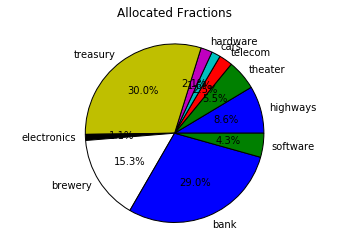

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

def display_pie(pie_values, pie_labels, colors=None,title=''):
    plt.axis("equal")
    plt.pie(pie_values, labels=pie_labels, colors=colors, autopct="%1.1f%%")
    plt.title(title)
    plt.show()
                                                           
display_pie( all_fracs.values(), all_fracs.keys(),title='Allocated Fractions')

## What-if analysis: trying different values for target return

The above model was solved with a 'hard coded' value of 9% for the target. 
Now, one can wonder how variance would vary if we changed this target return value.

In this part, we will leverage DOcplex model edition capabilities to explore different scenarios with different target return values.
We will run the model for target return values betwen 4% and 20%. For each possible target return value,
we modify the right-hand side (or _rhs_) of the `ct_target` constraint we kept as a variable, and solve again,
keeping the values in a list.


In [46]:
target_returns = range(5,21)  # from 5 to 20, included
variances = []
for target in target_returns:
    # modify the constraint's right hand side.
    ct_return.rhs = target
    cur_s = mdl.solve(url=url, key=key)
    assert cur_s  # solve is OK
    cur_variance = variance.solution_value
    print('- for a target return of: {0}%, variance={1}'.format(target, cur_variance))
    variances.append(cur_variance)

- for a target return of: 5%, variance=0.281052522094
- for a target return of: 6%, variance=0.281052522144
- for a target return of: 7%, variance=0.28105252225
- for a target return of: 8%, variance=0.308185908696
- for a target return of: 9%, variance=0.405577349404
- for a target return of: 10%, variance=0.550343525005
- for a target return of: 11%, variance=0.741794573128
- for a target return of: 12%, variance=0.979845964693
- for a target return of: 13%, variance=1.25989354438
- for a target return of: 14%, variance=1.58137555404
- for a target return of: 15%, variance=1.94422359461
- for a target return of: 16%, variance=2.34695923313
- for a target return of: 17%, variance=2.78898505456
- for a target return of: 18%, variance=3.27072840942
- for a target return of: 19%, variance=3.79250399539
- for a target return of: 20%, variance=4.35431181013


Again we use `matplotlib` to print variances vs. target returns.

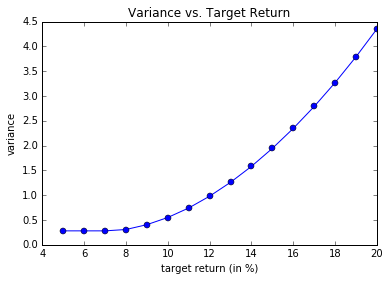

In [47]:
plt.plot(target_returns, variances, 'bo-')
plt.title('Variance vs. Target Return')
plt.xlabel('target return (in %)')
plt.ylabel('variance')
plt.show()

Not surprisingly, variance is increasing with target return.